# Identification Of Physical Strain Data From Two Noisy Interferometers

# Motivation

On September14, 2015,both instruments of the LaserInterferometer Gravitational-wave Observatory(LIGO)observed strain data consistentwith the detection of gravitational wavesfrom the merger of twomassive objects.Many advanced computational techniques were used to extract the true physical data from the extremely sensitive interferometers in the LIGO experiment.I do not knowthese techniques. Instead I will attempt to machine learn my way to the true data. 

The two noisy distributions, $H(t), L(t)$, can be thought of as a single element of their product space. This space is equippedwith a probability distribution dependent on a parameter, $\theta(t)$.This parameter is the true physical event that occursand is picked up by the detectors. In essence, a physical strain is picked up by the detectors. However, the detectors are noisy, so an additional noise function is added, one for H, and onefor L. The noise distributions are random, and dependent on which detector it is from(ie, H has different noise than L), and independentfrom each other. 

# Model

The fundamental approximation that will allow this method to be used is the assumption that the noise power is gaussian and time independant.

One desires to estimate some underlying physical strain event $\theta (t)$ and subtract it off from the detector destribtution to find the noise distribution:
$$N_H(t) = H(t) - \theta(t)$$

When the power spectrum desnity of the $N_H$ and $N_L$ is taken, it is then possible to calculate the probability of the H and L detector readings occuring simultaneously

$$P = P(N_H) P(N_L) = \prod_i P(PSD_i = f(\omega)) \prod_k P(PSD_k = g(\omega))$$

Where $PSD_i$ is the PSD for the $i$'th time bin in the time series. Since for each time bin, the PSD probabilities are assumed to be independant (because it is a model of noise)

The probabilitiy of the PSD is modelled as a gaussian and independant in each frequency as follows:

$$P(PSD_i = f(\omega)) \approx \prod_j \frac{1}{2\pi \sigma_j^2}e^{-\frac{1}{2}\frac{(PSD_{ij}-\mu_j)^2}{\sigma_j^2}}$$

Where j corresponds to a frequency bin and i corresponds to a time bin

Our objective is then to do gradient ascent on $\theta$ to find the maximum likelyhood $\theta$. Calculating the gradient with respect to $\tilde{\theta}{ij}$

$$\partial_{ij, real} P =  2(\frac{PSD_{ij, N_H}}{\sigma_{ij, H}^2} (-H^* - H+2 \theta_{real}) + \frac{PSD_{ij, N_L}}{\sigma_{ij, L}^2}(-L^* - L+2 \theta_{real}))P$$

$$\partial_{ij, imag} P =  2(\frac{PSD_{ij, N_H}}{\sigma_{ij, H}^2}(-H^* + H+2 \theta_{imag}) + \frac{PSD_{ij, N_L}}{\sigma_{ij, L}^2}(-L^* + L+2 \theta_{imag}))P$$

Where derivation has been omitted for brevity.

Since all elements of the gradient contain a factor of P, one can divide through an avoidi computing a ridiculously small probability value. Once it is possible to calculate this, it is possible to do gradient ascent to find the maximum likelyhood estimator. 

# Data$^1$
The preparation of data is as follows and is code from an official ligo tutorial. THIS IS NOT MY CODE UNTIL EXPERIMENT SECTION

In [14]:
import os
## this code fixes the current working directory and is designed to only run once
def fixdir(isrun):
    if isrun == False:
        os.chdir("data_files")
        path = os.getcwd()
        isrun = True
        print(path)
    return True
isrun = fixdir('isrun' in locals())

In [15]:
eventname = 'GW150914' 
make_plots = 1
plottype = "png"

# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
import readligo as rl


In [16]:
# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [17]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


In [18]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
    print(fn_H1)
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

H-H1_LOSC_4_V2-1126259446-32.hdf5


C:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [19]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]


1126259462.44


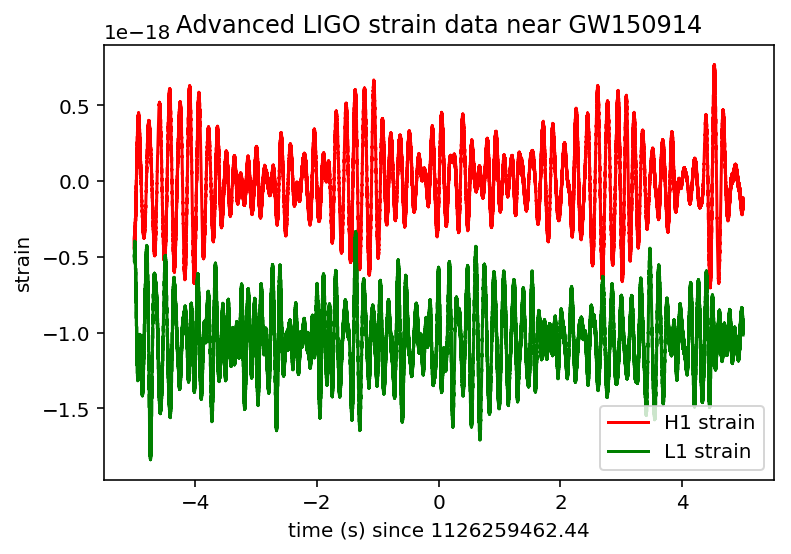

In [20]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

# Experiments

Begin My code

Normalize data

In [21]:
from sklearn import preprocessing
h1strain = preprocessing.normalize(strain_H1.reshape(1, -1))[0]
l1strain = preprocessing.normalize(strain_L1.reshape(1, -1))[0]

In [22]:
h1strain = h1strain/(np.max(h1strain)-np.min(h1strain))
l1strain = l1strain/(np.max(l1strain)-np.min(l1strain))


Create Time series`

In [23]:
nbins = 1000
num = int(np.floor(len(h1strain)/1000))
h1x = np.zeros([1000, num])
l1x = h1x
for i in np.arange(1000):
    h1x[i, :] = h1strain[i*num:i*num+num] - np.average(h1strain[i*num:i*num+num])
    l1x[i, :] = l1strain[i*num:i*num+num] - np.average(l1strain[i*num:i*num+num])

Below is function to get power spectrum from time domain

In [24]:
def get_psd(arr, fft = True):
    if fft == True:
        
        arr = np.fft.fft(arr, axis = 1)
    lenth = int(arr.shape[1]/2)
    bins = arr.shape[0]
    
    psd = np.zeros([bins, lenth])
    
    for i in np.arange(bins):
        for j in np.arange(lenth):
            psd[i, j] = arr[i, j].real**2 +  arr[i, j].imag**2 +  arr[i, -j-1].real**2 + arr[i, -j-1].imag**2
    return psd

In [25]:

h1fft = np.fft.fft(h1x)
l1fft = np.fft.fft(l1x)

h1psd = get_psd(h1x)
l1psd = get_psd(l1x)

Gaussian Parameters

In [26]:
haverages = np.average(h1psd, axis = 0)
laverages = np.average(l1psd, axis = 0)
hvars = np.var(h1psd, axis = 0)
lvars = np.var(l1psd, axis = 0)

Do gradient ascent to estimate maximum likelyhood $\theta$

In [27]:
theta  = np.zeros(h1fft.shape)
grad = np.zeros(h1fft.shape)
iterations = 5
for k in np.arange(iterations):
    nh = get_psd(h1fft-theta, fft = False) ##get noise psd
    nl = get_psd(l1fft-theta, fft = False)

    for i in np.arange(grad.shape[0]):
        for j in np.arange(grad.shape[1]):
            if j >=nh.shape[1]: ##it must be noted that the psd has half the parameters of the fourier transform

                indexj = -(j -nh.shape[1] ) 
            else:
                indexj = j
            gradreal = 2*(nh[i, indexj]/hvars[indexj]**2*(np.conj(-h1fft[i, j]) - h1fft[i, j] + 2*theta[i, j].real) + nl[i, indexj]/lvars[indexj]**2 *(np.conj(-l1fft[i, j]) - l1fft[i, j] + 2*theta[i, j].real))
            gradim = gradreal = 2*(nh[i, indexj]/hvars[ indexj]**2*(np.conj(-h1fft[i, j]) + h1fft[i, j] + 2*theta[i, j].imag) + nl[i, indexj]/lvars[indexj]**2 *(np.conj(-l1fft[i, j]) + l1fft[i, j] + 2*theta[i, j].imag))
            grad[i, j] = gradreal + gradim
            
    theta = theta + grad


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [28]:
theta = np.fft.fft(theta)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


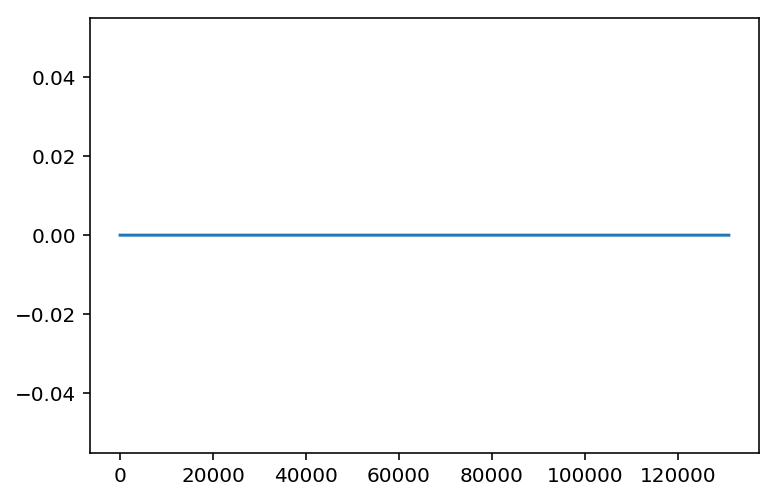

In [29]:
theta = theta.flatten()
plt.plot(theta)

**References**

1. BINARY BLACK HOLE SIGNALS IN LIGO OPEN DATA, Version 1.63, 2017 Sept 11, https://www.gw-openscience.org/static/events/LOSC_Event_tutorial.ipynb